In [1]:
%matplotlib inline
from pathlib import Path
from time import monotonic, sleep

import numpy as np
import matplotlib.pyplot as plt
import math

import qcodes as qc
from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.dataset.descriptions.detect_shapes import detect_shape_of_measurement
from qcodes.logger import start_all_logging
start_all_logging()

from scipy.optimize import curve_fit
import numpy as np

from ultolib import (anritsu, korad, spincore)
from ultolib.spincore import pulse
import qcodes.instrument_drivers.stanford_research as stanford_research

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\mqst_admin\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\mqst_admin\.qcodes\logs\240322-14716-qcodes.log


In [2]:
# Note : this will generate two deprecation warnings when creating the pulse_blaster
pulse_blaster = spincore.PulseBlasterESRPRO(name='pulse_blaster', board_number=0)
pulse_blaster.core_clock(500)                     #Sets the clock speed, 
                                                  #must be called immediately after connecting to the PulseBlaster

lock_in_amp = stanford_research.SR830(name='lock_in_amp', address='ASRL5::INSTR', terminator='\r')

microwave_src=anritsu.MG3681A(name='microwave_src', address='ASRL4::INSTR', terminator='\r\n')
microwave_src.output('OFF')
microwave_src.IQ_modulation('EXT')
microwave_src.output_level_unit('dBm')

dc_supply = korad.KD3305P('dc_supply', 'ASRL6::INSTR')
dc_supply.ch1.voltage_setpoint(0)
dc_supply.ch1.current_setpoint(0)

pulse_blaster.stop()

Connected to: Stanford_Research_Systems SR830 (serial:s/n32132, firmware:ver1.07) in 0.78s
Connected to: ANRITSU MG3681A (serial:6100146424, firmware:3.03) in 0.23s
Connected to: KORAD KD3005P V6.7 SN 48562561 (serial:None, firmware:None) in 0.05s


0

## Preparation
Input the parameters you determined in the ramsey Finges template below before continuing to the Hahn echo experiment.

In [ ]:
dc_supply.ch1.voltage_setpoint(12)
dc_supply.ch1.current_setpoint(#Your Current Setpoint Here)

microwave_src.frequency(#Determined Resonance Frequency Here)
microwave_src.power(#Your Microwave Power Here)

T_X_pi = #Enter the pi rotation pulselength for the Q-channel here.
T_Y_pi = #Enter the pi rotation pulselength for the I-channel here.
T_X_pi_2 = T_X_pi / 2
T_Y_pi_2 = T_Y_pi / 2

## CPMG

A CPMG pulse sequence adds to the Hahn echo in Task 3 by performing the refocusing pulsein a way that makes it robust to pulse errors. A 1-pulse CPMG pulse sequence looks as follows:

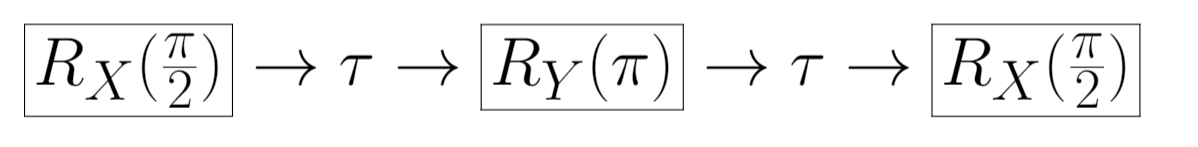

The pulse sequence can be extended by adding $R_y(\pi)$ pulses between the two $R_x(\pi/2)$ pulses. For example, a two pulse CPMG sequence is  $R_x(\pi/2) \rightarrow R_y(\pi) \rightarrow R_y(\pi) \rightarrow R_x(\pi/2)$.

Define the number of pulses below.

In [ ]:
N_CPMG_pulses = 2

#Use this to make a parameter out of anything!
FPT = qc.Parameter("Precession", unit = 's')
LI_R = qc.ManualParameter('Signal', unit='V')

#We start by stopping the laser pulsing. This way we can properly initialize.
initialise_or_create_database_at(Path.cwd() / f"CPMG{N_CPMG_pulses}.db")
experiment = load_or_create_experiment(
    experiment_name=f'CPMG{N_CPMG_pulses}',
    sample_name=""
)

meas = Measurement(exp=experiment, name=f'CPMG{N_CPMG_pulses}')
meas.register_parameter(FPT)  # register the first independent parameter
meas.register_parameter(LI_R) # now register the dependent oone

Now construct the CPMG pulse sequence below, the timing parameters have been already been defined for you. 

For example, the 2-pulse CPMG - using the below timing parameters -  should look like:

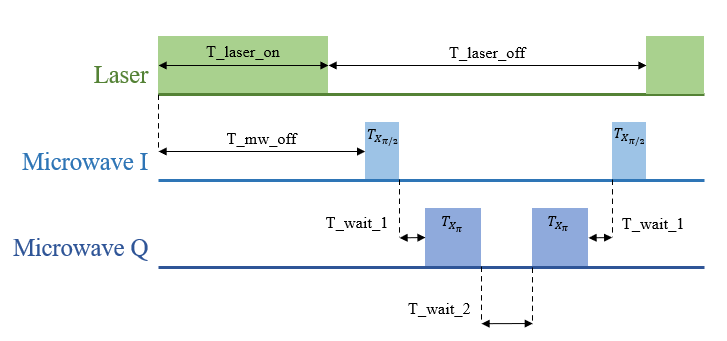

where the free precession time $\tau$ is 2 $\times$ T_wait_2 + 2 $\times$ T_wait_1 and T_wait_2 is double T_wait_1. 

For the 4-pulse CPMG set the laser modulation frequency (laser_f) to 20 kHz. Set the duty cycle (laser_D) to 0.2.

In [ ]:
ref_f =                                      #Reference frequency.
ref_D =                                      #Reference duty cycle.
T_ref_on = ref_D/ref_f                       #Reference time on.
T_ref_off = (1 - ref_D)/ref_f                #Reference time off.

laser_f =                                    #Laser modulation frequency.
laser_D =                                    #Laser modulation duty cycle.
T_laser_on =                                 #Laser time on. 
T_laser_off =                                #Laser time off.
N_laser_pulses =                             #Number of laser pulses that can fit in the reference period.
N_mw_pulses =                                #Number of Microwave Pulses
    
def get_T_wait_1(t_free_prec):
    return #Your T_wait_1 code here
    
def get_T_wait_2(t_free_prec):
    return #Your T_wait_2 code here

def get_T_mw_off(t_free_prec):
    return #Your T_mw_off code here

def CPMG_PP(t_free_prec):
    #TODO: Fill out the pulse sequences below.
    pulse_blaster.reset_channel_buffer()         #Clear the previous pulse sequence.
    pulse_blaster.ch0.pulse_sequence_buffer.set(
        #TODO: Enter the lock-in reference pulse sequence.
    )                                            
    pulse_blaster.ch1.pulse_sequence_buffer.set(
        #TODO: Enter the laser pulse sequence.
    )                                           
    pulse_blaster.ch2.pulse_sequence_buffer.set(
        #TODO: Enter the 'I' microwave modulation pulse sequence.
    )
    pulse_blaster.ch3.pulse_sequence_buffer.set(
        #TODO: Enter the 'Q' microwave modulation pulse sequence.
    )

t_free_prec_0 =  320e-9
CPMG_PP(t_free_prec_0)
pulse_blaster.plot_channel_buffer()          #This function plots the newly defined pulse sequence.

In [ ]:
lock_in_amp.time_constant(#Your Time Constant Here)
lock_in_amp.sensitivity(100e-6)

#Set your start/finish times and the step size.
fpt_s = 320e-9
fpt_f = 20.16e-6
step_fpt = 320e-9

Before performing the 4-pulse CPMG, change from:

fpt_s = 320e-9, fpt_f = 20.16e-6, step_fpt = 320e-9, and lock_in_amp.sensitivity(100e-6)

to:

fpt_s = 640e-9, fpt_f = 30.08e-6, step_fpt = 640e-9, and lock_in_amp.sensitivity(50e-6)

In [ ]:
microwave_src.output('ON')
with meas.run() as datasaver:
    ##########################
    #Your experiment code here
        
    ##########################
    CPMG_data = datasaver.dataset  # convenient to have for data access and plotting

CPMG = CPMG_data.to_pandas_dataframe()

Repeat the task with 2 and 4 pulses. If you have time attemp an 8-pulse CPMG. Record and compare your $T_2^{CPMG}$. In your own time, fit the data to the appropriate model and extract $T_2^{CPMG}$. You must show both the fit and $T_2^{CPMG}$ in your lab report. 

#### Q3. For a particular τ, how do the center frequencies of the bandpass filter functions created by the 3 different CPMG pulse sequences compare? Based on this understanding, what type of noise is most likely associated with the dephasing of the spins? Finally, as before, explain why a CPMG pulse sequence decays in the direction that you observe in your experiment?

##### Turn off the instruments

In [ ]:
pulse_blaster.stop()
microwave_src.output('OFF')
dc_supply.ch1.voltage_setpoint(0)
dc_supply.ch1.current_setpoint(0)